In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile('/content/dataset.zip', 'r') as zObject:

    # Extracting specific file in the zip
    # into a specific location.
    zObject.extractall(path="/content/")
zObject.close()

In [7]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

# Achitecture of the Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, 5)
        self.max_pool1 = nn.MaxPool2d(4, 4)

        self.conv2 = nn.Conv2d(8, 16, 5)
        self.max_pool2 = nn.MaxPool2d(5, 5)

        self.conv3 = nn.Conv2d(16, 32, 5)
        self.max_pool3 = nn.MaxPool2d(5, 5)

        self.lin1 = nn.Linear(32, 128)
        self.lin2 = nn.Linear(128, 84)
        self.lin3 = nn.Linear(84, 9)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.max_pool3(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)
        x = F.relu(x)

        x = self.lin3(x)

        return x


# Define a function to calculate accuracy
def calculate_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        running_loss = 0
        for data in loader:
            inputs, labels = data
            outputs = net(inputs.to(device))
            running_loss += torch.nn.CrossEntropyLoss()(outputs.to(device), labels.to(device)).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    return (100 * correct / total), running_loss


# Define the initial dataset directory with all the images
dataset_directory = 'dataset'

# Define the output directory for saving the training and testing data
output_directory = 'dataset-refactor'
train_dir = os.path.join(output_directory, 'training')
test_dir = os.path.join(output_directory, 'testing')

# Define the dump dataset directory where I will sore the dups
dump_directory = 'dataset-dumb'
dump_train_dir = os.path.join(dump_directory, 'training')
dump_test_dir = os.path.join(dump_directory, 'testing')

if not os.path.isdir(dump_directory):
    # Create subdirectories for training and testing data
    os.makedirs(train_dir)
    os.makedirs(test_dir)

    # Create the directories for training and testing data
    os.makedirs(dump_train_dir)
    os.makedirs(dump_test_dir)

    # Define the number of images per class for training and testing
    images_per_class       = 10000
    images_per_class_train = 8000
    images_per_class_test  = images_per_class - images_per_class_train

    # List of class names
    class_names = sorted(['Circle', 'Square', 'Octagon', 'Heptagon', 'Nonagon', 'Star', 'Hexagon', 'Pentagon', 'Triangle'])

    # Loop through each class
    for class_name in class_names:
        # Create the folder
        os.makedirs(f'{train_dir}/{class_name}')
        os.makedirs(f'{test_dir}/{class_name}')

        # List all image files in the dataset directory
        image_files = [f for f in os.listdir(dataset_directory) if f.endswith('.png') and class_name in f]

        # Randomly shuffle the image files
        random.shuffle(image_files)

        # Split the image files into training and testing sets
        train_images = image_files[:images_per_class_train]
        test_images = image_files[images_per_class_train:]

        # Copy images to the appropriate directories
        for image in train_images:
            src = os.path.join(dataset_directory, image)
            dst = os.path.join(f'{train_dir}/{class_name}', image)
            shutil.copy(src, dst)

        for image in test_images:
            src = os.path.join(dataset_directory, image)
            dst = os.path.join(f'{test_dir}/{class_name}', image)
            shutil.copy(src, dst)

    # Create datasets and data loaders
    transform     = transforms.Compose([transforms.Resize((200, 200)), transforms.ToTensor()])
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

    # Save the datasets to files
    torch.save(train_dataset, dump_train_dir + '/training.file')
    torch.save(test_dataset, dump_test_dir + '/testing.file')

# Data structures to store the loss and the accuracy
train_loss = list()
train_acc  = list()
test_loss  = list()
test_acc   = list()

# Hyper-parameters
learning_rate = 0.001
batch_size    = 100
epochs        = 10
device        = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define data transformations
transform = transforms.Compose([transforms.ToTensor()])

# Define the same neural network architecture as in the training code
net = Net().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Load the train and test files

training_files = torch.load('/content/' + dump_train_dir + '/training.file')
trainloader = torch.utils.data.DataLoader(training_files, batch_size=batch_size, shuffle=True)

testing_files = torch.load('/content/' + dump_test_dir + '/testing.file')
testloader = torch.utils.data.DataLoader(testing_files, batch_size=batch_size, shuffle=False)

# Train the neural network
for epoch in range(epochs):
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    acc, _ = calculate_accuracy(trainloader)
    train_acc.append(acc)
    train_loss.append(running_loss / len(trainloader))

    acc, loss = calculate_accuracy(testloader)
    test_acc.append(acc)
    test_loss.append(loss / len(testloader))

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Train Accuracy: {train_acc[-1]}%, Test Accuracy: {test_acc[-1]}%')

print('Finished Training')
torch.save(net.state_dict(), '/content/drive/My Drive/0602-651340543-NEGRO.ZZZ')

plt.plot(train_loss, c = 'b', label='Train Loss')
plt.plot(test_loss, c = 'r', label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('/content/drive/My Drive/loss_best.png',dpi=400, bbox_inches='tight', transparent=True)
plt.clf()

plt.plot(train_acc, c = 'b', label='Train Accuracy')
plt.plot(test_acc, c = 'r', label='Test Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('/content/drive/My Drive/accuracy_best.png', dpi=400, bbox_inches='tight', transparent=True)
plt.clf()


Epoch 1, Loss: 1.6333674305842982, Train Accuracy: 57.56111111111111%, Test Accuracy: 57.416666666666664%
Epoch 2, Loss: 0.8743851654231548, Train Accuracy: 70.28888888888889%, Test Accuracy: 69.41666666666667%
Epoch 3, Loss: 0.6289064759181605, Train Accuracy: 79.37083333333334%, Test Accuracy: 78.76666666666667%
Epoch 4, Loss: 0.518558806553483, Train Accuracy: 78.04583333333333%, Test Accuracy: 77.38888888888889%
Epoch 5, Loss: 0.45744082315100565, Train Accuracy: 83.89722222222223%, Test Accuracy: 82.86111111111111%
Epoch 6, Loss: 0.3978435865913828, Train Accuracy: 85.30972222222222%, Test Accuracy: 84.02777777777777%
Epoch 7, Loss: 0.36085290879838994, Train Accuracy: 83.6763888888889%, Test Accuracy: 82.17222222222222%
Epoch 8, Loss: 0.32631062989433607, Train Accuracy: 85.62361111111112%, Test Accuracy: 84.32777777777778%
Epoch 9, Loss: 0.309779499978241, Train Accuracy: 89.7875%, Test Accuracy: 87.94444444444444%
Epoch 10, Loss: 0.2906233286071155, Train Accuracy: 89.919444444

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, labels, classes):
    plt.figure(figsize=(10, 5))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0))
                   / 2 + 0.5)  # Unnormalize and display the image
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.savefig('plot/dataset.png', dpi=400, bbox_inches='tight', transparent=True)

In [14]:
training_files = torch.load('training.pt')
testing_files = torch.load('testing.pt')

training_files, testing_files

FileNotFoundError: [Errno 2] No such file or directory: 'training.pt'

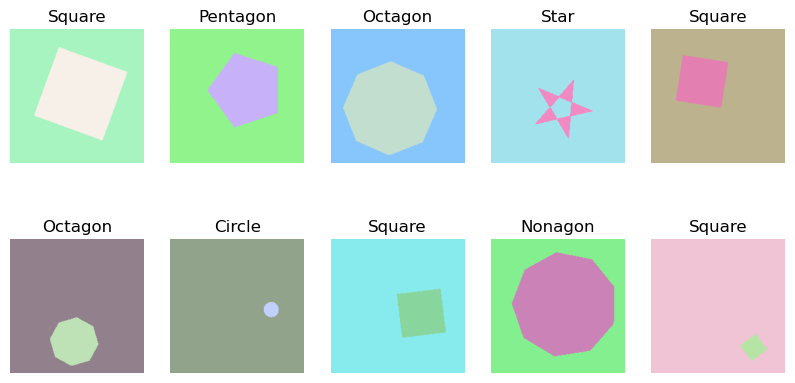

In [18]:
# Create a DataLoader for easy batch processing
training_files = torch.load('dataset-dumb/training/training.file')
trainloader = torch.utils.data.DataLoader(training_files, batch_size=10, shuffle=True)

class_names = sorted(['Circle', 'Square', 'Octagon', 'Heptagon', 'Nonagon', 'Star', 'Hexagon', 'Pentagon', 'Triangle'])

dataiter = iter(trainloader)
images, labels = next(dataiter)
show_images(images, labels, class_names)

Epoch 1, Loss: 1.9217476083172693, Train Accuracy: 32.709722222222226%, Test Accuracy: 32.63333333333333%
Epoch 2, Loss: 1.562933126423094, Train Accuracy: 42.419444444444444%, Test Accuracy: 41.483333333333334%
Epoch 3, Loss: 1.3564511792113383, Train Accuracy: 50.91111111111111%, Test Accuracy: 50.41111111111111%
Epoch 4, Loss: 1.2088542962239848, Train Accuracy: 53.61527777777778%, Test Accuracy: 53.03888888888889%
Epoch 5, Loss: 1.0962840010722479, Train Accuracy: 60.12777777777778%, Test Accuracy: 59.9%
Epoch 6, Loss: 0.9866130994011958, Train Accuracy: 64.20972222222223%, Test Accuracy: 63.48888888888889%
Epoch 7, Loss: 0.9095285171435938, Train Accuracy: 67.0%, Test Accuracy: 66.04444444444445%
Epoch 8, Loss: 0.8286009525259336, Train Accuracy: 68.30694444444444%, Test Accuracy: 67.95%
Epoch 9, Loss: 0.7574888813412852, Train Accuracy: 71.47638888888889%, Test Accuracy: 70.87777777777778%
Epoch 10, Loss: 0.6933953182771802, Train Accuracy: 73.30694444444444%, Test Accuracy: 72.5

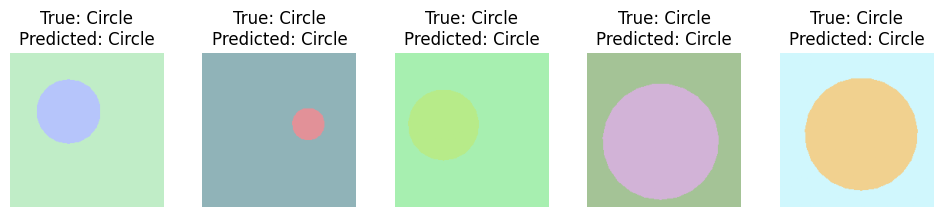

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import os
import shutil

from torchvision.datasets import ImageFolder

names = ["Circle", "Square", "Octagon", "Heptagon", "Nonagon", "Star", "Hexagon", "Pentagon", "Tringle"]
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
batch_size = 50
epochs = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, 5)
        self.max_pool1 = nn.MaxPool2d(7, 7)

        self.conv2 = nn.Conv2d(8, 16, 5)
        self.max_pool2 = nn.MaxPool2d(10, 10)

        self.lin1 = nn.Linear(64, 128)
        self.lin2 = nn.Linear(128, 9)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)

        return x

# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define the same neural network architecture as in the training code
net = Net().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

training_files = torch.load('/content/' + dump_train_dir + '/training.file')
trainloader = torch.utils.data.DataLoader(training_files, batch_size=batch_size, shuffle=True)

testing_files = torch.load('/content/' + dump_test_dir + '/testing.file')
testloader = torch.utils.data.DataLoader(testing_files, batch_size=batch_size, shuffle=False)

# Define a function to calculate accuracy
def calculate_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = net(inputs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    return (100 * correct / total)

# Train the neural network
for epoch in range(epochs):  # Change the number of epochs as needed
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_accuracy = calculate_accuracy(trainloader)
    test_accuracy = calculate_accuracy(testloader)
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Train Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%')

print('Finished Training')
torch.save(net.state_dict(), '/content/drive/My Drive/smaller_model.pth')

plt.plot(train_loss, c = 'b', label='Train Loss')
plt.plot(test_loss, c = 'r', label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('/content/drive/My Drive/loss_second.png',dpi=400, bbox_inches='tight', transparent=True)
plt.clf()

plt.plot(train_acc, c = 'b', label='Train Accuracy')
plt.plot(test_acc, c = 'r', label='Test Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('/content/drive/My Drive/accuracy_second.png', dpi=400, bbox_inches='tight', transparent=True)
plt.clf()

Epoch 1, Loss: 1.8193487729463311, Train Accuracy: 36.236111111111114%, Test Accuracy: 35.93333333333333%
Epoch 2, Loss: 1.392879113389386, Train Accuracy: 44.1%, Test Accuracy: 43.733333333333334%
Epoch 3, Loss: 1.215221651064025, Train Accuracy: 52.34722222222222%, Test Accuracy: 52.12777777777778%
Epoch 4, Loss: 1.1005178509073126, Train Accuracy: 58.00694444444444%, Test Accuracy: 57.03333333333333%
Epoch 5, Loss: 1.018930613497893, Train Accuracy: 59.93472222222222%, Test Accuracy: 59.18333333333333%
Epoch 6, Loss: 0.9566210026542346, Train Accuracy: 61.079166666666666%, Test Accuracy: 60.18333333333333%
Epoch 7, Loss: 0.9049702514376905, Train Accuracy: 63.895833333333336%, Test Accuracy: 63.077777777777776%
Epoch 8, Loss: 0.8587982004301415, Train Accuracy: 67.75972222222222%, Test Accuracy: 66.85%
Epoch 9, Loss: 0.8198418368688888, Train Accuracy: 68.05277777777778%, Test Accuracy: 66.85555555555555%
Epoch 10, Loss: 0.7889761239704158, Train Accuracy: 67.59166666666667%, Test A

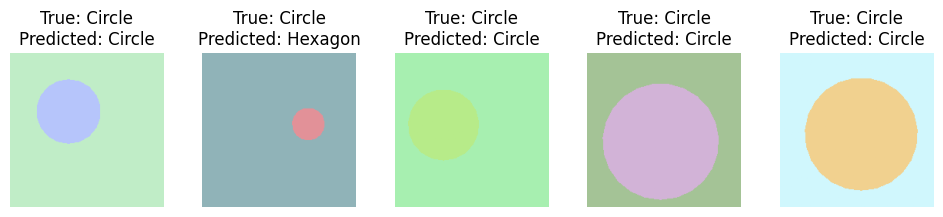

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import os
import shutil

from torchvision.datasets import ImageFolder

names = ["Circle", "Square", "Octagon", "Heptagon", "Nonagon", "Star", "Hexagon", "Pentagon", "Tringle"]
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
batch_size = 50
epochs = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.max_pool0 = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 8, 5)
        self.max_pool1 = nn.MaxPool2d(5, 5)

        self.conv2 = nn.Conv2d(8, 16, 5)
        self.max_pool2 = nn.MaxPool2d(7, 7)

        self.lin1 = nn.Linear(64, 128)
        self.lin2 = nn.Linear(128, 9)

    def forward(self, x):
        x = self.max_pool0(x)

        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)

        return x

# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define the same neural network architecture as in the training code
net = Net().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

training_files = torch.load('/content/' + dump_train_dir + '/training.file')
trainloader = torch.utils.data.DataLoader(training_files, batch_size=batch_size, shuffle=True)

testing_files = torch.load('/content/' + dump_test_dir + '/testing.file')
testloader = torch.utils.data.DataLoader(testing_files, batch_size=batch_size, shuffle=False)

# Define a function to calculate accuracy
def calculate_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = net(inputs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    return (100 * correct / total)

# Train the neural network
for epoch in range(epochs):  # Change the number of epochs as neede
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_accuracy = calculate_accuracy(trainloader)
    test_accuracy = calculate_accuracy(testloader)
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Train Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%')

print('Finished Training')
torch.save(net.state_dict(), '/content/drive/My Drive/smallest_model.pth')

plt.plot(train_loss, c = 'b', label='Train Loss')
plt.plot(test_loss, c = 'r', label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('/content/drive/My Drive/loss_first.png',dpi=400, bbox_inches='tight', transparent=True)
plt.clf()

plt.plot(train_acc, c = 'b', label='Train Accuracy')
plt.plot(test_acc, c = 'r', label='Test Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('/content/drive/My Drive/accuracy_first.png', dpi=400, bbox_inches='tight', transparent=True)
plt.clf()

In [10]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

name = []
image = []
image_path = '.'

for i in sorted(os.listdir(image_path)):
    if os.path.splitext(i)[-1] == '.png':
      name.append(i)
      image.append(Image.open(os.path.join(image_path, i)))
image = list(map(lambda i: transforms.Compose([transforms.ToTensor()])(i).unsqueeze(0), image))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, 5)
        self.max_pool1 = nn.MaxPool2d(4, 4)

        self.conv2 = nn.Conv2d(8, 16, 5)
        self.max_pool2 = nn.MaxPool2d(5, 5)

        self.conv3 = nn.Conv2d(16, 32, 5)
        self.max_pool3 = nn.MaxPool2d(5, 5)

        self.lin1 = nn.Linear(32, 128)
        self.lin2 = nn.Linear(128, 84)
        self.lin3 = nn.Linear(84, 9)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.max_pool3(x)

        x = torch.flatten(x, 1)

        x = self.lin1(x)
        x = F.relu(x)

        x = self.lin2(x)
        x = F.relu(x)

        x = self.lin3(x)

        return x

net = Net()
net.load_state_dict(torch.load('/content/drive/MyDrive/0602-651340543-NEGRO.ZZZ'))
net.eval()

names = sorted(['Circle', 'Heptagon', 'Hexagon', 'Nonagon', 'Octagon', 'Pentagon', 'Square', 'Star', 'Triangle'])
solutions = list(zip(name, list(map(lambda k: names[k], list(map(lambda l: net(l).argmax().item(), image))))))

with open('prediction.txt', 'w') as f:
  for i in solutions:
      print(f'{i[0]}: {i[1]}')
      f.write(f'{i[0]}: {i[1]}\n')


img1.png: Circle
img2.png: Hexagon
img3.png: Triangle
